In [1]:
!rm -rf /kaggle/working/multimodal-eq-sizing
!git clone https://github.com/brianrp09232000/multimodal-eq-sizing.git /kaggle/working/multimodal-eq-sizing
!pip install -r /kaggle/working/multimodal-eq-sizing/requirements.txt

Cloning into '/kaggle/working/multimodal-eq-sizing'...
remote: Enumerating objects: 874, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 874 (delta 149), reused 100 (delta 97), pack-reused 671 (from 3)
Receiving objects: 100% (874/874), 1009.62 KiB | 13.46 MiB/s, done.
Resolving deltas: 100% (534/534), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.4 MB/s eta 0:00:00:

# Modules

In [2]:
import sys
import pathlib

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

import sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

import os

In [3]:
start_time = datetime.now()

In [4]:
np.seterr(invalid="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [5]:
# Uses the current directory where the notebook is running
repo_root = pathlib.Path("multimodal-eq-sizing")
sys.path.append(str(repo_root.resolve())) # .resolve() gets the full absolute path locally

In [6]:
from src.models import price_mlp 
from src.models.price_mlp import rmse, summarize_price_model_diagnostics
from src.models.price_mlp import select_feature_columns, scale_features, create_sliding_windows_single_stock
from src.models.price_mlp import split_single_stock, build_panel_dataset
from src.utils.cv import make_yearly_walkforward_splits, generate_yearly_oof, _train_predict_year

2025-12-09 05:38:01.839306: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765258682.115471      75 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765258682.191310      75 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

# Read Data

In [7]:
df = pd.read_pickle("/kaggle/input/nasdaq-news/proc_multimodal_eq_sizing_dataset.pkl")

# Drop na

In [8]:
df = df.dropna(axis=0, how='any')

# Configurations

In [9]:
################# Configurations #######################
DATA_PATH  = "/kaggle/working/final_dataset.csv"   
DATE_COL   = "Date"                    
TICKER_COL = "ticker"                  
TARGET_COL = 'next_day_excess_return'             

FEATURE_COLS = [
 'mom_rank',
 'spy_r1',
 'o2c_return',
 'excess_return',
 'VIX_Close',
 'VIX_z',
 'spread_z',
 'dollar_volume',
 'adv_dollar',
    'mom_12_1',
 'next_day_excess_return' ]

WINDOW_SIZE = 30        
TEST_RATIO  = 0.20      
VAL_RATIO   = 0.10      

BATCH_SIZE   = 64
EPOCHS       = 30
LEARNING_RATE = 1e-3
DROPOUT_RATE = 0.2
GRU_UNITS    = 128
LSTM_UNITS   = 128
DENSE_UNITS  = 64

# Select Feature Columns

In [10]:
def select_feature_columns(df: pd.DataFrame):
    """
    Decide which features to use：
    - if FEATURE_COLS is not None，use this function；
    - o/w use all numerical cols，excluding Date and ticker
    """
    global FEATURE_COLS

    if FEATURE_COLS is not None:
        missing = [c for c in FEATURE_COLS if c not in df.columns]
        if len(missing) > 0:
            raise ValueError(f"FEATURE_COLS is not in the dataset: {missing}")
    else:
        exclude_cols = {DATE_COL, TICKER_COL}
        FEATURE_COLS = [
            c for c in df.columns
            if c not in exclude_cols and pd.api.types.is_numeric_dtype(df[c])
        ]
        print("Auto selected FEATURE_COLS:", FEATURE_COLS)

    if TARGET_COL not in FEATURE_COLS:
        raise ValueError(
            f"TARGET_COL='{TARGET_COL}'must included in the FEATURE_COLS，"
        )

    return FEATURE_COLS

In [11]:
feature_cols = select_feature_columns(df) 

# Split Data

In [12]:
def split_data_on_year(df, DATE_COL, split_year):

    # split by date
    df_train = df[df[DATE_COL] < str(split_year-1)+'-01-01']
    df_val = df[df[DATE_COL] >= str(split_year-2)+'-01-01']
    df_val = df_val[df_val[DATE_COL] < str(split_year)+'-01-01']
    df_test = df[df[DATE_COL] >= str(split_year)+'-01-01']
    df_test = df_test[df_test[DATE_COL] < str(split_year+2)+'-01-01']

    return df_train, df_val, df_test

# create X_train, y_train, X_val, y_val, X_test, y_test

In [13]:
def create_numpy_data_type(df_train, df_val, df_test, feature_cols, TARGET_COL):

    
    y_train = np.array(df_train[TARGET_COL])
    y_val = np.array(df_val[TARGET_COL])#.dropna())
    y_test = np.array(df_test[TARGET_COL])#.dropna())
    
    model_input_cols = feature_cols.copy()
    model_input_cols.remove(TARGET_COL)

    X_train = np.array(df_train[model_input_cols])#.dropna(axis=1))
    X_val = np.array(df_val[model_input_cols])#.dropna(axis=1))
    X_test = np.array(df_test[model_input_cols])#.dropna(axis=1))

    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Normalize Data

In [14]:
def normalize_data(xtrain, xval, xtest):

    xscaler = MinMaxScaler(feature_range=(0, 1))
    xtrain = xscaler.fit_transform(xtrain)
    xval = xscaler.transform(xval)
    xtest = xscaler.transform(xtest)
    return xtrain, xval, xtest, xscaler

# Reshape Data

In [15]:
def reshape_data(xtrain, xval, xtest):

    xtrain = xtrain.reshape(xtrain.shape[0], xtrain.shape[1], 1)
    xval = xval.reshape(xval.shape[0], xval.shape[1], 1)
    xtest = xtest.reshape(xtest.shape[0], xtest.shape[1], 1)
    
    #print(xtrain.shape, ytrain.shape, xval.shape,yval.shape, xtest.shape,ytest.shape)
    return xtrain, xval, xtest

# Model Function

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import Adam

####################### Build hybrid GRU LSTM model ###################

def build_hybrid_gru_lstm(input_shape):
    """
    input_shape: (WINDOW_SIZE, num_features)

    Input
      → GRU(128, return_sequences=True) + Dropout(0.2)
      → LSTM(128) + Dropout(0.2)
      → Dense(64, relu)
      → Dense(1, linear)
    """
    inputs = layers.Input(shape=input_shape)

    x = layers.GRU(
        GRU_UNITS,
        return_sequences=True,
        dropout=DROPOUT_RATE
    )(inputs)

    x = layers.LSTM(
        LSTM_UNITS,
        dropout=DROPOUT_RATE
    )(x)

    x = layers.Dense(DENSE_UNITS, activation="relu")(x)
    outputs = layers.Dense(1, activation="linear")(x)

    model = models.Model(inputs=inputs, outputs=outputs, name="Hybrid_GRU_LSTM")

    optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(
        optimizer=optimizer,
        loss="mse",
        metrics=["mae"]
    )

    return model

# Model

In [17]:
def build_model_for_one_fold(df, feature_cols, TARGET_COL, DATE_COL, split_year):
    
    # split data by year
    df_train, df_val, df_test = split_data_on_year(df, DATE_COL, split_year)
    
    # create train, val, and test dataset
    X_train, y_train, X_val, y_val, X_test, y_test = create_numpy_data_type(df_train, 
                                                                             df_val, 
                                                                             df_test,
                                                                             feature_cols,
                                                                            TARGET_COL)
    
    # normalize data
    X_train, X_val, X_test, xscaler = normalize_data(X_train, X_val, X_test)
    
    # reshape input data
    X_train, X_val, X_test = reshape_data(X_train, X_val, X_test)
    
    # build model
    model = build_hybrid_gru_lstm(X_train[0].shape)
    
    # early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, 
                       restore_best_weights=True)
    # Compile
    #model.compile(loss='mse', optimizer=Adam(learning_rate=0.0001), metrics=['mse'])
    
    model.compile(
            optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
            loss="mse",
            metrics=["mae"]
        )
    
    # fit network
    history = model.fit(X_train, y_train, epochs=EPOCHS, verbose=2, batch_size=64, 
                        validation_data=(X_val, y_val), callbacks=[es])
    
    # predict test data
    y_pred = model.predict(X_test).flatten()
    df_test['y_pred'] = y_pred
    
    # evaluate model
    summarize_price_model_diagnostics(model, history, split_year)
    
    
    y_test = y_test.flatten()
    mse  = mean_squared_error(y_test, y_pred)
    mae  = mean_absolute_error(y_test, y_pred)
    r_mse = price_mlp.rmse(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Test MSE      : {mse:.6f}")
    print(f"Test RMSE     : {r_mse:.6f}")
    print(f"Test MAE      : {mae:.6f}")
    print(f"Test R2 score : {r2}")
    print()

    return df_test, model

In [20]:
def summarize_price_model_diagnostics(model, history, year):
  """plots price model loss and accuracy curves of the train and validation data
  inputs: model - tensorflow model; history - model.fit output
  outputs: none"""
  fig, ax = plt.subplots(1,2, figsize=(20, 10))
  # plot loss
  ax[0].set_title(model.name+str(year)+': Loss Curves', fontsize=20)
  ax[0].plot(history.history['loss'], label='train')
  ax[0].plot(history.history['val_loss'], label='validation')
  ax[0].set_xlabel('Epochs', fontsize=15)
  ax[0].set_ylabel('Loss', fontsize=15)
  ax[0].legend(fontsize=15)
  # plot mae
  ax[1].set_title(model.name+str(year)+': MAE Curves', fontsize=20)
  ax[1].plot(history.history['mae'], label='train')
  ax[1].plot(history.history['val_mae'], label='validation')
  ax[1].set_xlabel('Epochs', fontsize=15)
  ax[1].set_ylabel('MAE', fontsize=15)
  ax[1].legend(fontsize=15)

Epoch 1/30
66/66 - 11s - 160ms/step - loss: 3.6310e-04 - mae: 0.0128 - val_loss: 2.1748e-04 - val_mae: 0.0101
Epoch 2/30
66/66 - 5s - 79ms/step - loss: 2.5258e-04 - mae: 0.0112 - val_loss: 2.2066e-04 - val_mae: 0.0102
Epoch 3/30
66/66 - 5s - 79ms/step - loss: 2.4961e-04 - mae: 0.0110 - val_loss: 2.0896e-04 - val_mae: 0.0097
Epoch 4/30
66/66 - 5s - 77ms/step - loss: 2.4049e-04 - mae: 0.0108 - val_loss: 2.1006e-04 - val_mae: 0.0097
Epoch 5/30
66/66 - 5s - 78ms/step - loss: 2.3869e-04 - mae: 0.0107 - val_loss: 2.1396e-04 - val_mae: 0.0099
Epoch 6/30
66/66 - 5s - 80ms/step - loss: 2.4019e-04 - mae: 0.0108 - val_loss: 2.0934e-04 - val_mae: 0.0097
Epoch 7/30
66/66 - 5s - 79ms/step - loss: 2.3750e-04 - mae: 0.0107 - val_loss: 2.0854e-04 - val_mae: 0.0097
Epoch 8/30
66/66 - 5s - 80ms/step - loss: 2.3879e-04 - mae: 0.0107 - val_loss: 2.1199e-04 - val_mae: 0.0098
Epoch 9/30
66/66 - 5s - 80ms/step - loss: 2.3825e-04 - mae: 0.0107 - val_loss: 2.1319e-04 - val_mae: 0.0099
Epoch 10/30
66/66 - 5s - 7

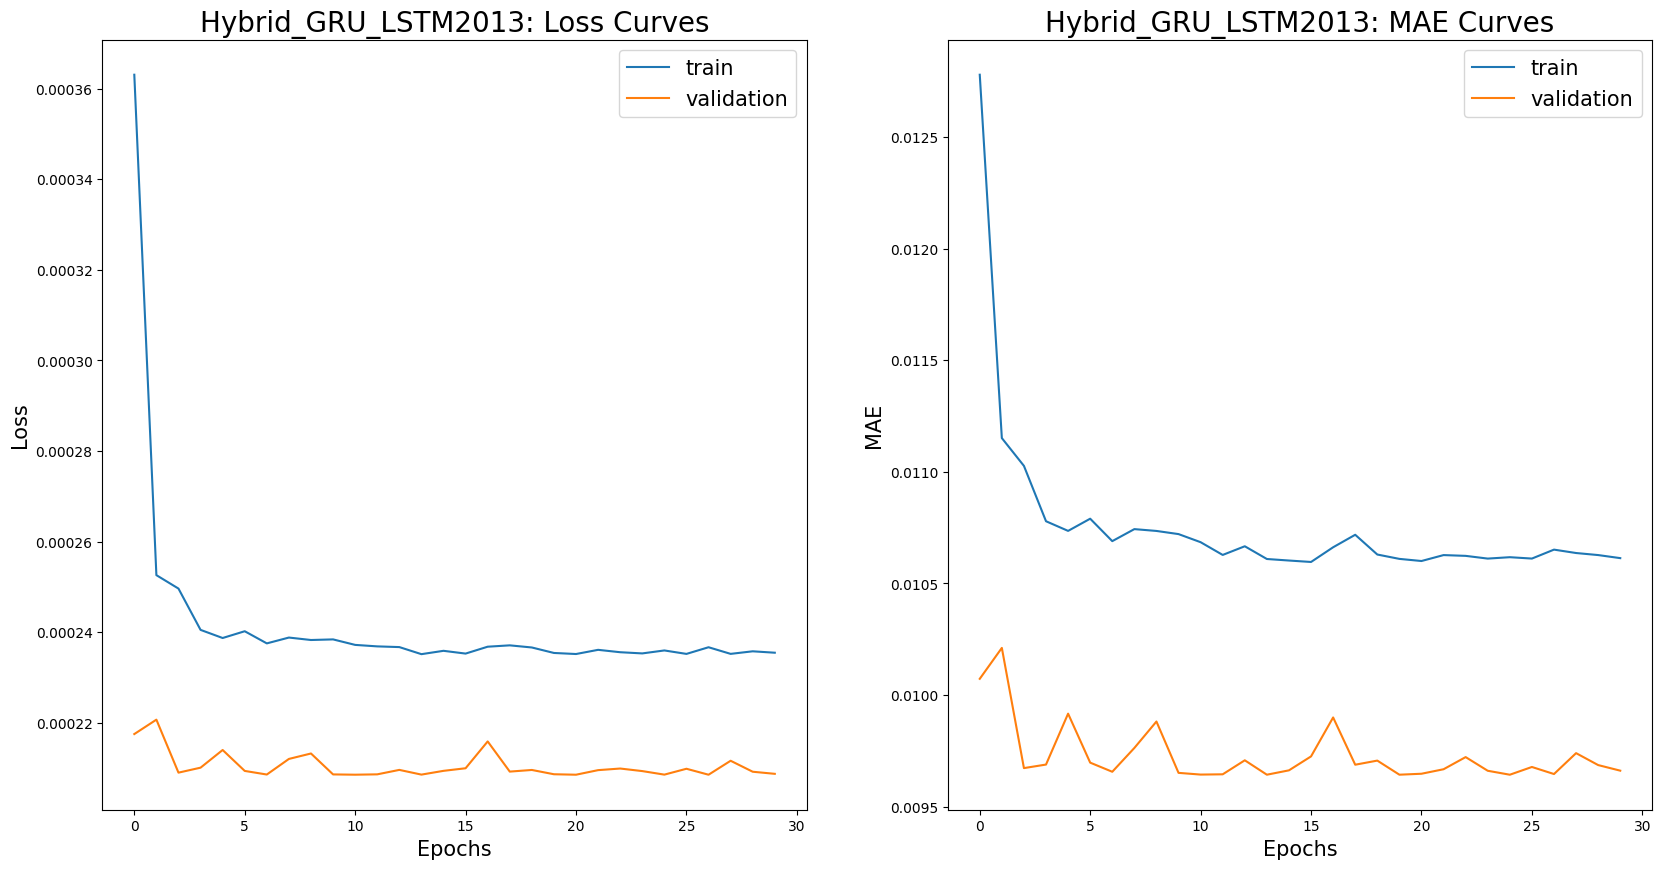

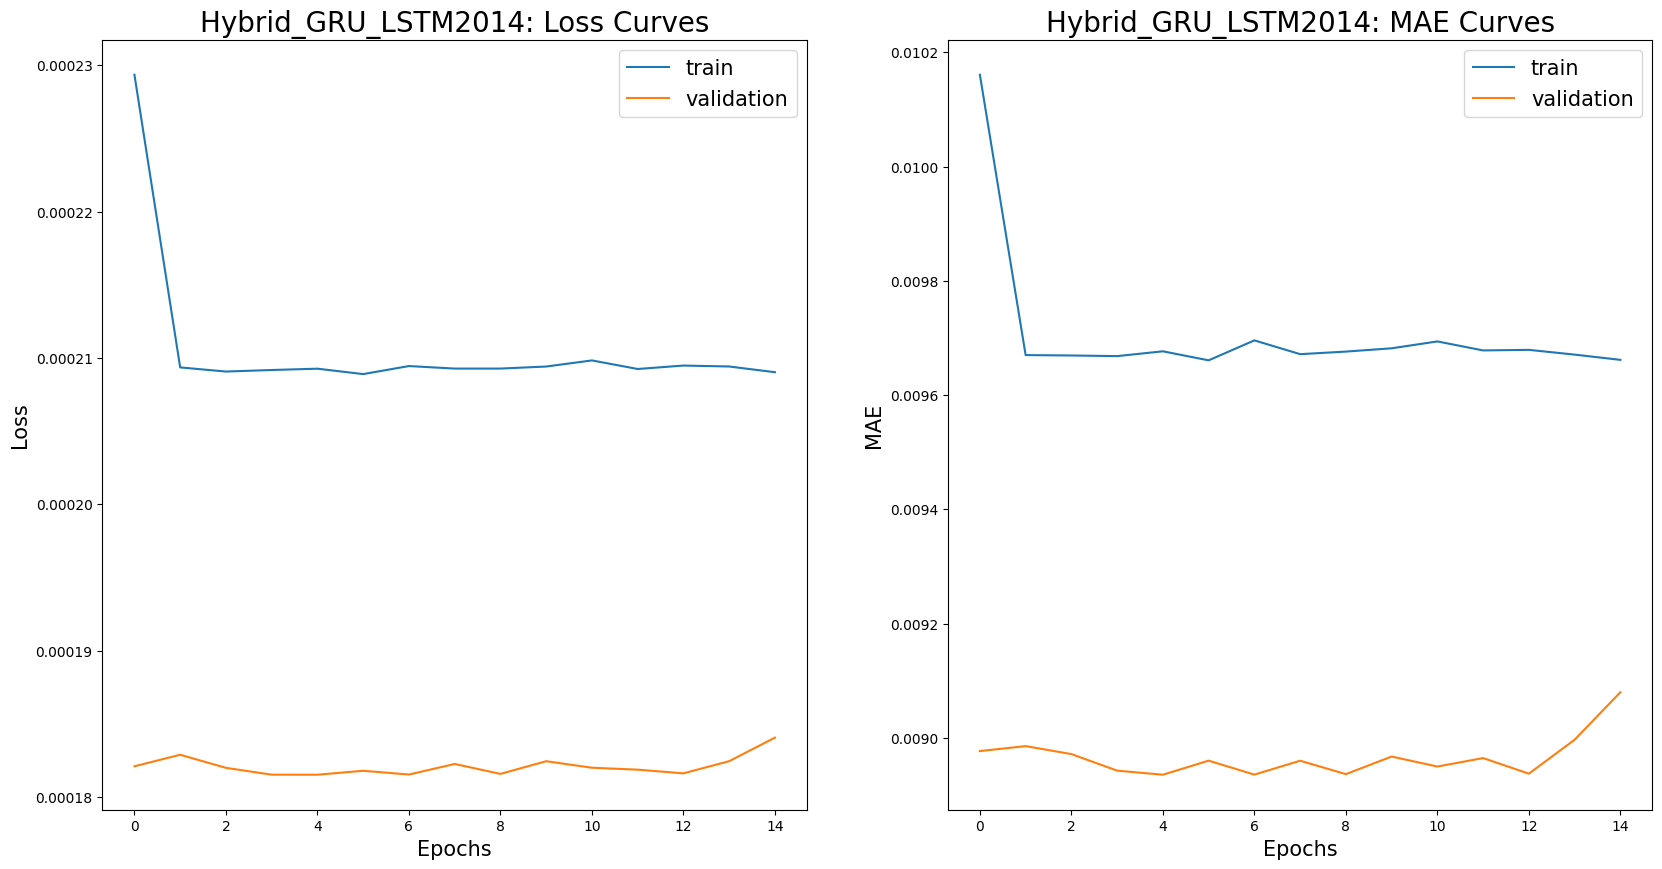

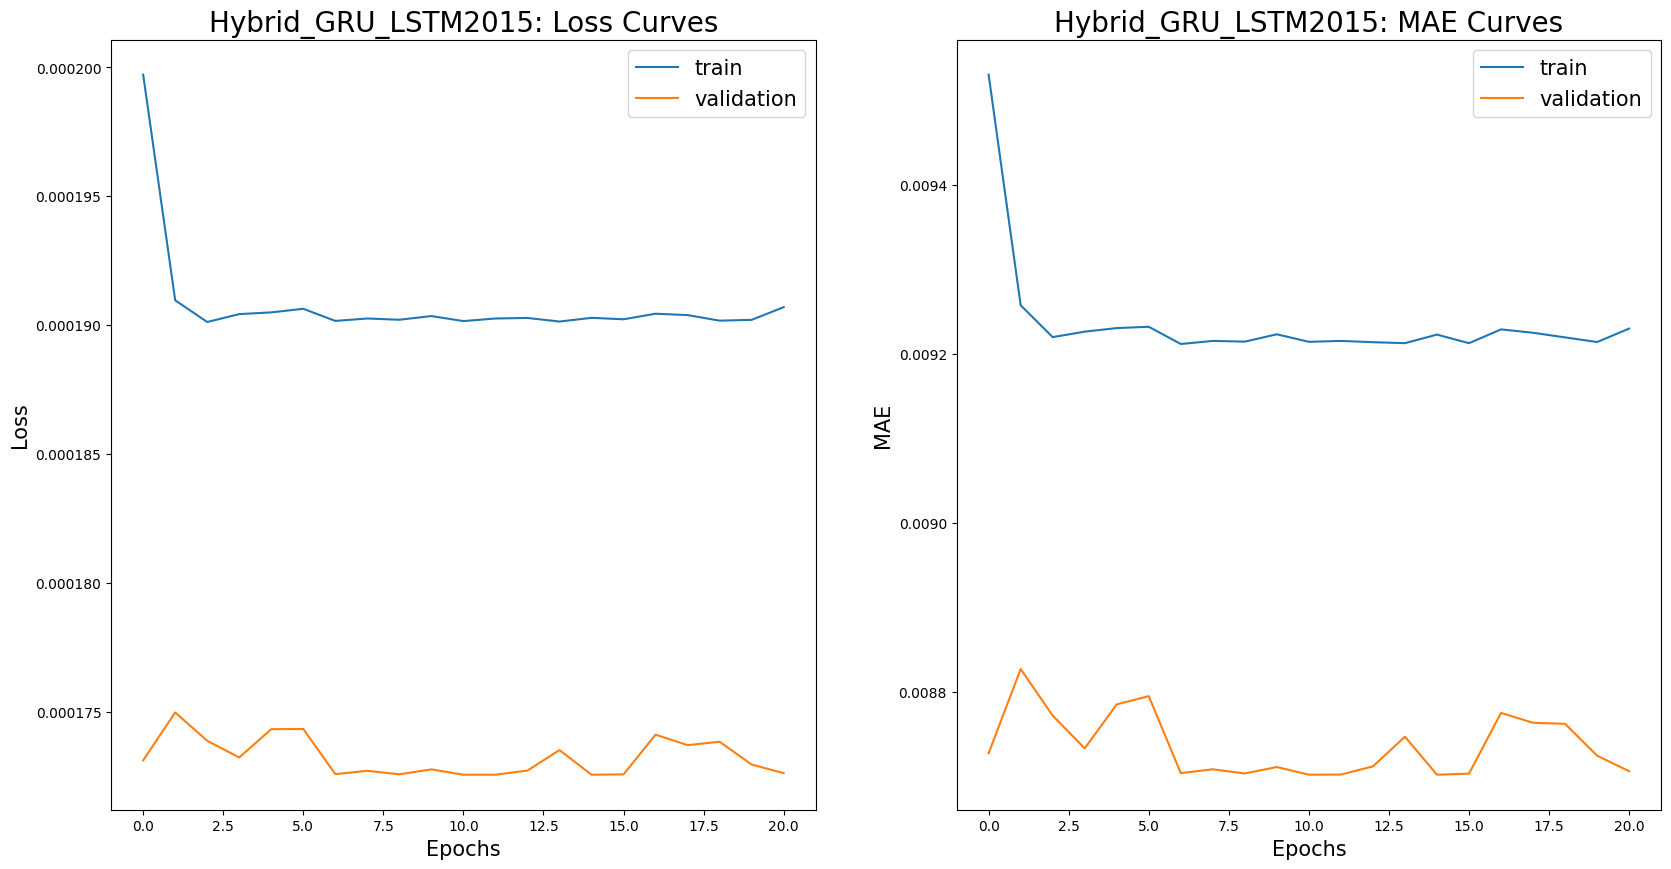

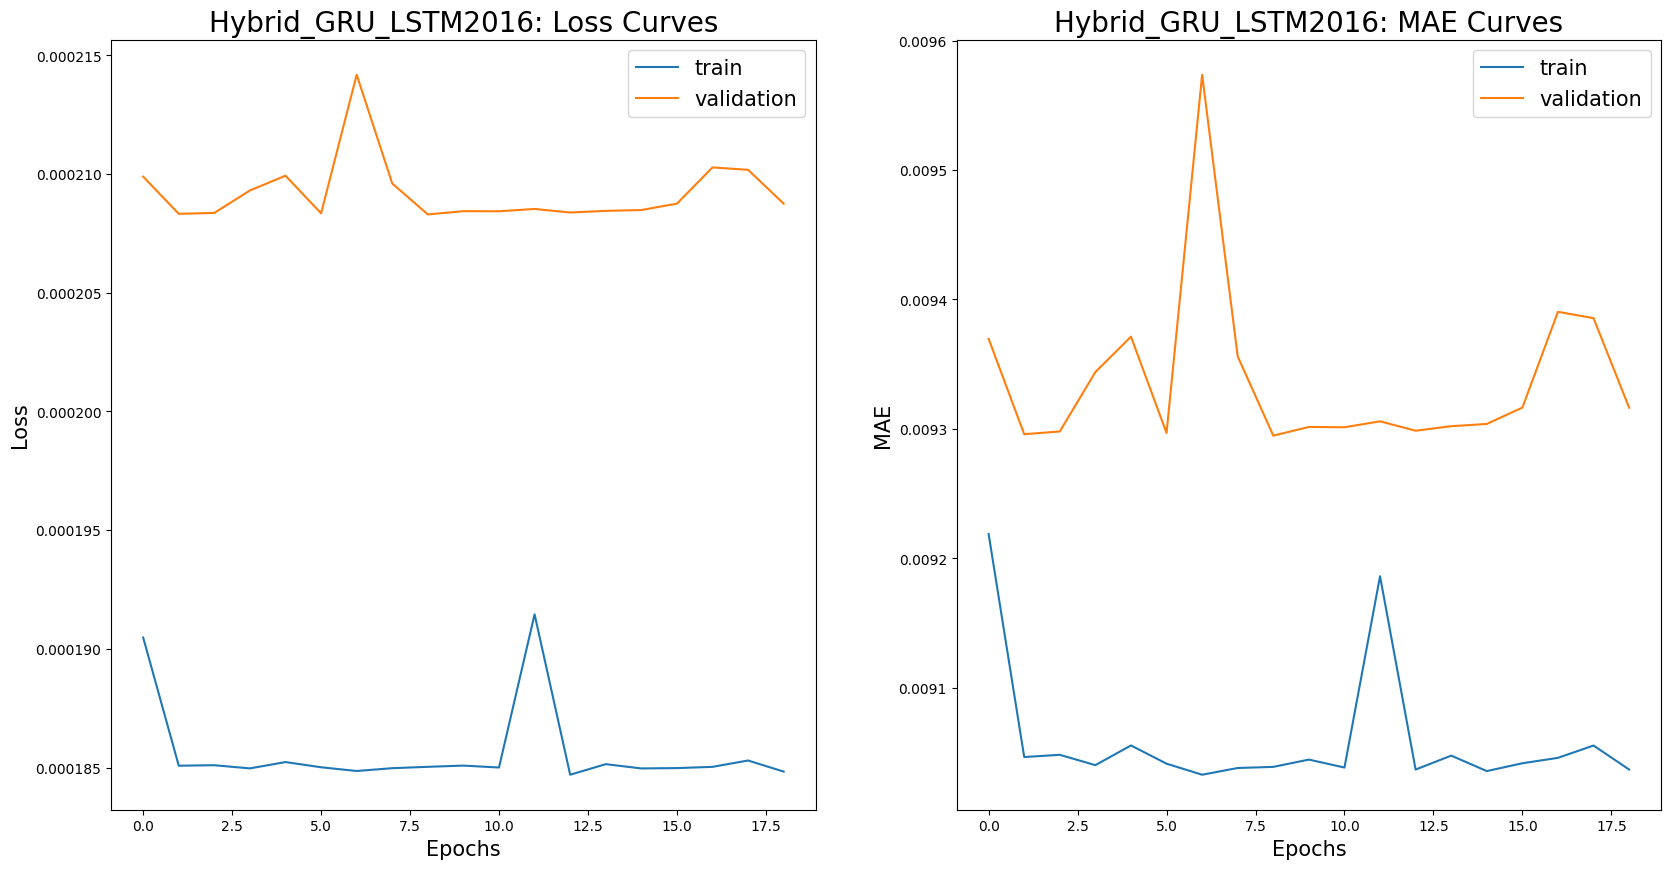

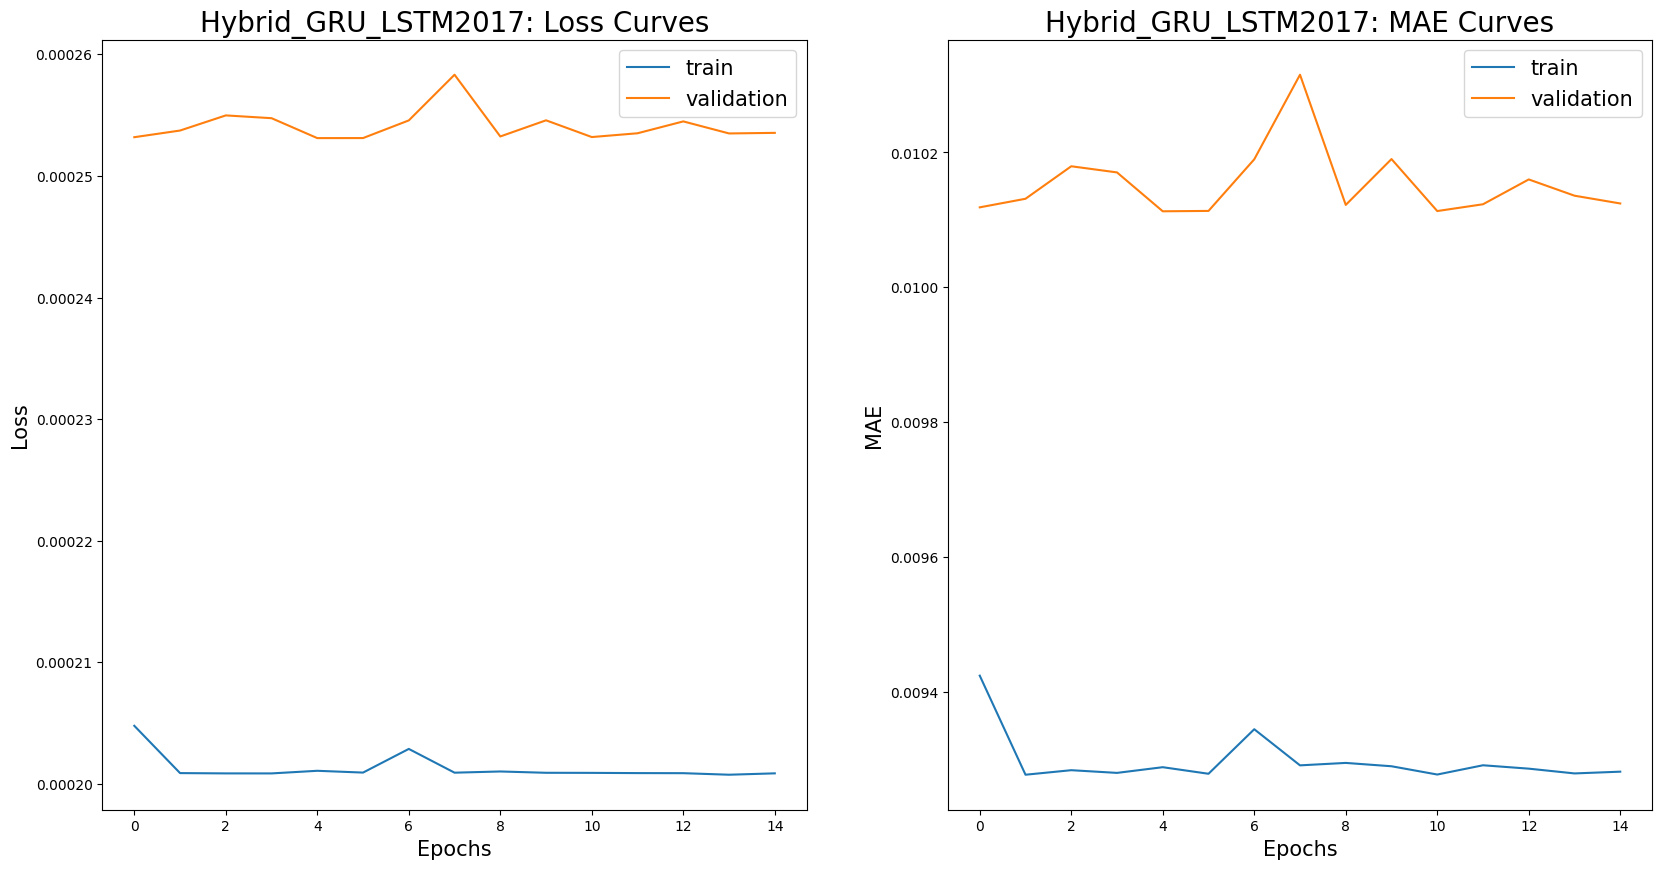

In [21]:
# build models spliting the dataset at different years
df_test_all = pd.DataFrame()
for split_year in [2013, 2014, 2015, 2016, 2017]:
    df_test, model = build_model_for_one_fold(df, feature_cols, TARGET_COL, DATE_COL, split_year)
    df_test_all = pd.concat([df_test_all, df_test])

# Write Files

In [22]:
df_test_all.to_csv('/kaggle/working/price_model_test_predicted.csv')

In [23]:
df_test_all.to_pickle('/kaggle/working/price_model_test_predicted.pkl')

In [24]:
# Save the price model 
model.save("/kaggle/working/price_model.keras")

In [25]:
import kagglehub
handle = "rocklaura/multimodal-eq-sizing"
local_dataset_dir = "/kaggle/working/"
current_datetime = datetime.now().isoformat()
kagglehub.dataset_upload(handle, local_dataset_dir, version_notes=current_datetime)

Uploading Dataset https://www.kaggle.com/datasets/rocklaura/multimodal-eq-sizing ...
More than 50 files detected, creating a zip archive...
Starting upload for file /tmp/tmpfovoq563/archive.zip


Uploading: 100%|██████████| 3.11G/3.11G [00:32<00:00, 95.9MB/s]

Upload successful: /tmp/tmpfovoq563/archive.zip (3GB)


Your dataset has been created.
Files are being processed...
See at: https://www.kaggle.com/datasets/rocklaura/multimodal-eq-sizing


In [26]:
!rm -rf /kaggle/working/multimodal-eq-sizing